In [1]:
# Import Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from tqdm import tqdm
import math
import gc

import os
print(os.listdir("../input"))

['sample_submission.csv', 'train.csv', 'test.csv', 'embeddings']


In [2]:
# Get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
### Checking GPU Set up
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [4]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)
## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values

In [6]:
def null_treatment(df):
    return df["question_text"].fillna("__NA__").values

train_texts = null_treatment(train_df)
val_texts   = null_treatment(val_df)
test_texts  = null_treatment(test_df)

In [7]:
del train_df


In [8]:
from keras.preprocessing.text import Tokenizer
max_features = 95000
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(np.concatenate([train_texts, val_texts, test_texts]))


Using TensorFlow backend.


In [9]:
from keras.preprocessing import sequence
train_sequences = tokenizer.texts_to_sequences(train_texts)
valid_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

del train_texts, val_texts, test_texts
gc.collect()

0

In [10]:
max_len = 100
train_X = sequence.pad_sequences(train_sequences, maxlen = max_len)
val_X = sequence.pad_sequences(valid_sequences, maxlen = max_len)
test_X = sequence.pad_sequences(test_sequences, maxlen = max_len)

del train_sequences, valid_sequences, test_sequences
gc.collect()

0

In [11]:
EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

embedding_matrix_1 = embedding_matrix
del embeddings_index , word_index, all_embs,embedding_matrix
gc.collect()

EMBEDDING_FILE = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


embedding_matrix = np.mean((embedding_matrix, embedding_matrix_1), axis=0)
del embedding_matrix_1,embeddings_index , word_index, all_embs
gc.collect()



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


0

In [12]:
import keras

class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i, layer in enumerate(self.model.layers):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [13]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [14]:
from keras import backend as K
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
    

def f1_calc(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
 

clr = CyclicLR(base_lr=0.001, max_lr=0.007,
                        step_size=300., mode='exp_range',
                        gamma=0.99994)

In [15]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNLSTM,CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers.normalization import BatchNormalization
from keras.layers import SpatialDropout1D,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate

maxlen = max_len
inp = Input(shape=(max_len,))
x = Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(inp)

x = SpatialDropout1D(0.2)(x)
x = Bidirectional(CuDNNLSTM(40, return_sequences=True))(x)
y = Bidirectional(CuDNNLSTM(40, return_sequences=True))(x)
    
atten_1 = Attention(max_len)(x) # skip connect
atten_2 = Attention(max_len)(y)
avg_pool = GlobalAveragePooling1D()(y)
max_pool = GlobalMaxPooling1D()(y)
    
conc = concatenate([atten_1, atten_2, avg_pool, max_pool])
conc = Dense(32, activation="relu")(conc)
conc = BatchNormalization(axis =1 )(conc)
conc = Dropout(0.1)(conc)
outp = Dense(1, activation="sigmoid")(conc)    

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[f1_calc])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     28500000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 80)      109440      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

In [16]:
tmp_path = "/tmp/tmp" 
model_path = "/tmp/model/"

swa = SWA('./keras_swa.model',4)

model.fit(train_X, train_y, batch_size=512, epochs= 10 ,callbacks = [swa,], validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Stochastic weight averaging selected for last 6 epochs.
Epoch 1/10
1175509/1175509 [==============================] - 312s 265us/step - loss: 0.1419 - f1_calc: 0.5320 - val_loss: 0.1382 - val_f1_calc: 0.6415
Epoch 2/10
1175509/1175509 [==============================] - 305s 260us/step - loss: 0.1084 - f1_calc: 0.5995 - val_loss: 0.1094 - val_f1_calc: 0.6628
Epoch 3/10
 689664/1175509 [================>.............] - ETA: 2:01 - loss: 0.1033 - f1_calc: 0.6264

In [17]:
# Load best model
try:
    print('using swa weight model')
    model.load_weights('./keras_swa.model')
except:
    model.load_weights('./keras.model')

using swa weight model


In [18]:
## Model design
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
 
SVG(model_to_dot(model).create(prog = "dot", format = "svg") )
 
from keras.utils import plot_model
plot_model(model, to_file = "../working/model.png") ##, show_shapes=True, show_layer_names=True)

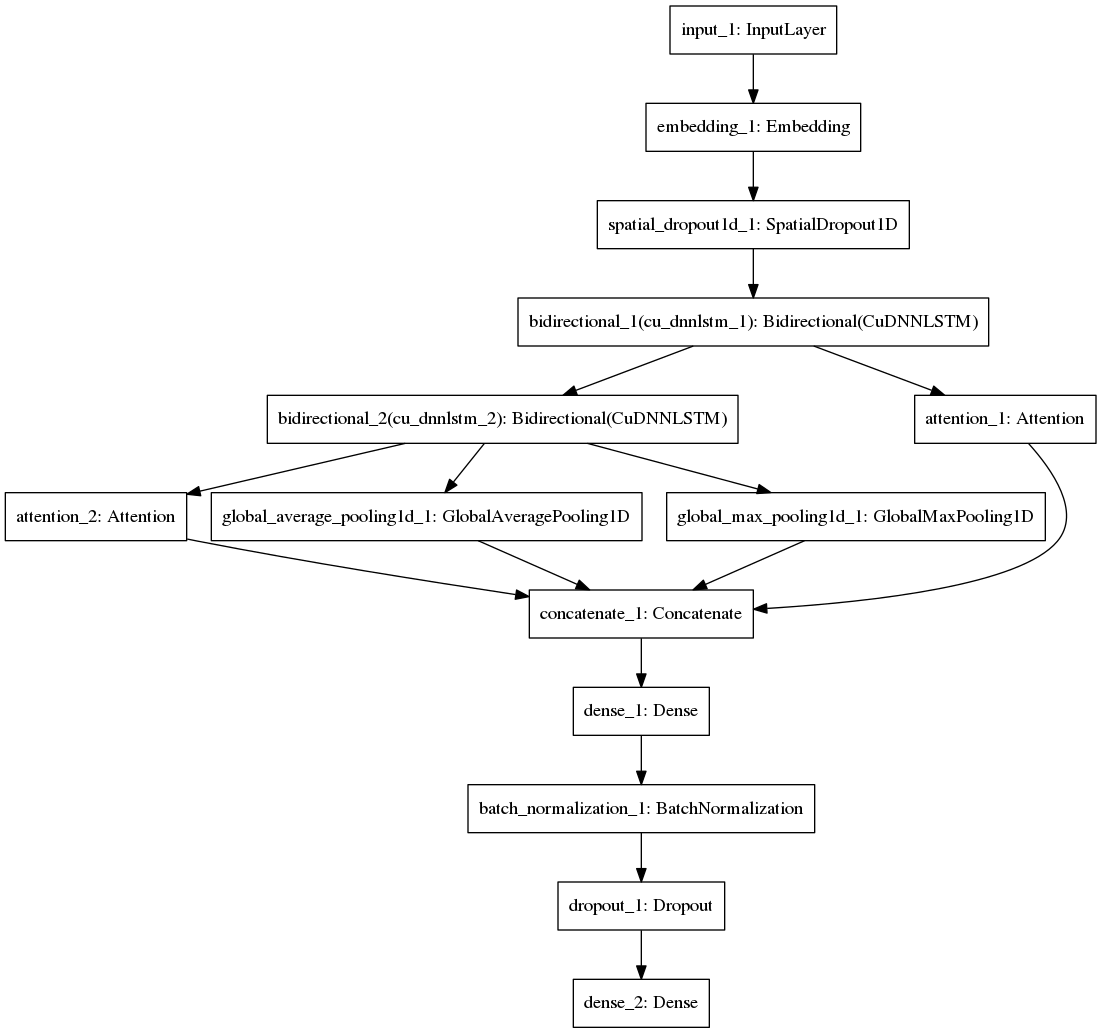

In [19]:
from IPython.display import Image
Image("../working/model.png")

In [20]:
from sklearn import metrics

pred_train_glLSTM_y = model.predict([train_X], batch_size=1024, verbose=1)
train_target = train_y

thresh_glLSTM = 0.5
f1_opt = 0
for thresh in np.arange(0.1, 0.91, 0.01):
    thresh = np.round(thresh, 2)
    f1_value = metrics.f1_score(train_target, (pred_train_glLSTM_y.astype(float) > thresh).astype(int))
    #print("F1 score at threshold {0} is {1}".format(thresh, f1))
    if f1_opt < f1_value:
        f1_opt = f1_value
        thresh_glLSTM = thresh
print(thresh_glLSTM)
pred_train_glLSTM_y_final = (pred_train_glLSTM_y > thresh_glLSTM).astype(np.int)
print(f1_score(train_target, pred_train_glLSTM_y_final))

1175509/1175509 [==============================] - 78s 67us/step
0.16
0.7358368889033645


In [21]:
pred_val_glLSTM_y = model.predict([val_X], batch_size=1024, verbose=1)
val_target = val_y

thresh_glLSTM = 0.5
f1_opt = 0
for thresh in np.arange(0.1, 0.91, 0.01):
    thresh = np.round(thresh, 2)
    f1_value = metrics.f1_score(val_target, (pred_val_glLSTM_y.astype(float) > thresh).astype(int))
    #print("F1 score at threshold {0} is {1}".format(thresh, f1))
    if f1_opt < f1_value:
        f1_opt = f1_value
        thresh_glLSTM = thresh
print(thresh_glLSTM)
#pred_val_bilstm_y_final = (pred_val_bigru_y > thresh_glLSTM).astype(np.int)
pred_val_bilstm_y_final = (pred_val_glLSTM_y > thresh_glLSTM).astype(np.int)
print(f1_score(val_target, pred_val_bilstm_y_final))

130613/130613 [==============================] - 9s 67us/step
0.16
0.6889561975768872


In [22]:
print(f1_score(train_target, (pred_train_glLSTM_y > thresh_glLSTM).astype(np.int)))

0.7358368889033645


In [23]:
pred_test_bilstm_y = model.predict([test_X], batch_size=1024, verbose=1)


375806/375806 [==============================] - 25s 66us/step


In [24]:
def most_false_negative(pred_y,true_y,thresh, N ):
    pred_y_round = (pred_y>thresh)
    
    flag = (pred_y_round == 0) & (true_y == 1)[:,np.newaxis]
    
    idxs = np.where(flag)[0] # ignore the np.newaxis dimension
    newidx = np.argsort(pred_y[idxs,0])

    return idxs[newidx[:N]], pred_y[idxs[newidx[:N]]]

def most_uncertain_negative(pred_y,true_y,thresh, N ):
    pred_y_round = (pred_y>thresh)
    flag = (pred_y_round == 0) & (true_y == 1)[:,np.newaxis]
    
    idxs = np.where(flag)[0] # ignore the np.newaxis dimension
    newidx = np.argsort(pred_y[idxs,0])
    return idxs[newidx[-N:]], pred_y[idxs[newidx[-N:]]]

def most_uncertain_positive(pred_y,true_y,thresh, N ):
    pred_y_round = (pred_y>thresh)
    
    flag = (pred_y_round == 1) & (true_y == 0)[:,np.newaxis]
    
    idxs = np.where(flag)[0] # ignore the np.newaxis dimension
    newidx = np.argsort(pred_y[idxs,0])

    return idxs[newidx[:N]], pred_y[idxs[newidx[:N]]]

def most_false_positive(pred_y,true_y,thresh, N ):
    pred_y_round = (pred_y>thresh)
    flag = (pred_y_round == 1) & (true_y == 0)[:,np.newaxis]
    
    idxs = np.where(flag)[0] # ignore the np.newaxis dimension
    newidx = np.argsort(pred_y[idxs,0])
    return idxs[newidx[-N:]], pred_y[idxs[newidx[-N:]]]

def most_true_positive(pred_y,true_y,thresh, N ):
    pred_y_round = (pred_y>thresh)
    
    flag = (pred_y_round == 1) & (true_y == 1)[:,np.newaxis]
    
    idxs = np.where(flag)[0] # ignore the np.newaxis dimension
    newidx = np.argsort(pred_y[idxs,0])

    return idxs[newidx[-N:]], pred_y[idxs[newidx[-N:]]]

In [25]:
# Example Count to explore for each question
NN = 10
## Validation prediction
pred =  pred_val_glLSTM_y
thresh_fin = thresh_glLSTM

In [26]:
##what are insincere topics where the network strongly believe to be sincere ?
idx, prob = most_false_positive( pred, val_y,thresh_fin,NN)
for i in range(NN):
    print('class',val_y[idx[i]],prob[i],val_df["question_text"].values[idx[i]])

class 0 [0.91142184] Why was it ok to use public funds to transport blacks to the polls to vote for Obama? Blacks who never voted in their life voted solely on color. Why isn't that racist? If whites proudly stated they voted for a white person it would never fly.
class 0 [0.9182942] If Muslim men cut their penis in childhood, then how are they able to pee and produce so many children?
class 0 [0.9206569] Why would a young, beautiful woman like Melania marry an old, fat bastard like Donald Trump?
class 0 [0.9273666] Should we kick out Muslims from India?
class 0 [0.92889756] Are Bangladeshi women ugly?
class 0 [0.9325481] Why don’t the Christian and Muslim quarter be under Palestinian control and the Jewish quarter be under Israeli control?
class 0 [0.93764615] Are Indians ruining Quora with their silly answers copied from Facebook and WhatsApp?
class 0 [0.94907016] If Mr. Frodo had asked Samwise Gamgee to castrate himself, would he have? How would Rosie react?
class 0 [0.96715164] Did

In [27]:
###what are sincere topics where the network strongly believe to be insincere ?
idx, prob = most_false_negative( pred, val_y,thresh_fin,NN)
for i in range(NN):
    print('class',val_y[idx[i]],prob[i],val_df["question_text"].values[idx[i]])

class 1 [1.0047527e-06] What if iam having bleeding after my regular periods on my ovulation day?
class 1 [1.940261e-06] What astrological combinations are needed to obtain a scholarship for studies?
class 1 [3.3018885e-06] How can I design a logo on PowerPoint?
class 1 [4.559017e-06] Is there any spot round in COMEDK? If yes, how is it conducting?
class 1 [1.332324e-05] What are some popular night spots in Chicago?
class 1 [1.5242949e-05] How many SITA devices are present in Ramayana?
class 1 [1.5345091e-05] How competitive is the hiring process at NVIDIA?
class 1 [1.994286e-05] How do I choose the best payday loan deal in Calgary?
class 1 [2.1206737e-05] How many karats needed for a karat farm?
class 1 [2.1854998e-05] How often do your gums bleed?


In [28]:
###what are the topics where the network are most uncertain how to classify ?
print('Keep in mind our chosen threshold is:')
print(thresh_fin)
print('\n')
NN_2 = np.int(NN/2)
idx, prob = most_uncertain_positive( pred, val_y,thresh_fin,NN_2)
for i in range(NN_2):
    print('class',val_y[idx[i]],prob[i],val_df["question_text"].values[idx[i]])
print('\n')

idx, prob = most_uncertain_negative( pred, val_y,thresh_fin,NN_2)
for i in range(NN_2):
    print('class',val_y[idx[i]],prob[i],val_df["question_text"].values[idx[i]])

Keep in mind our chosen threshold is:
0.16


class 0 [0.16011325] Do all overweight and obese people binge?
class 0 [0.16024299] Do preachers who keep affirming "Biblical inerrancy" have integrity or are they irresponsible to their congregation?
class 0 [0.16028625] Why so many Indians in US prefer to live abridged versions of Indian life, starting from selecting spouses & culture, imstead of assimilating?
class 0 [0.16035472] Why do taurus people love so hard?
class 0 [0.16044523] How can change gay hormones in a straight man?


class 1 [0.15925789] Israel is the cause of all the worlds problems why does it exist?
class 1 [0.15939191] Do smart people pretend to believe in god in order to fit in with stupider people around them?
class 1 [0.15946251] What will the people that insist Donald Trump colluded with Russia say when he is still president on Jan 19, 2021?
class 1 [0.15958627] Was Hitler a furry?
class 1 [0.15961424] How many times has Prince Harry had intimate relations with the

In [29]:
###what are insincere topics where the network strongly believes correctly ?
idx, prob = most_true_positive( pred, val_y,thresh_fin,NN)
for i in range(NN):
    print('class',val_y[idx[i]],prob[i],val_df["question_text"].values[idx[i]])

class 1 [0.98243356] Can a son have sexual intercourse with his mother?
class 1 [0.9829297] I want to have sex with my elder sister in . how can I?
class 1 [0.9832184] How can a human perform self-castration? God has requested I mutilate myself, but I was hoping there was a better way than cutting open my scrotum, pulling out my testicle and severing the spermatic cord.
class 1 [0.9833286] Why cant I have sex with my mom?
class 1 [0.984144] Mother's, would you be okay for trying to fuck your 30 yr old son if you were single, lived with him and his dick was big?
class 1 [0.98487896] Why are the Quora moderators fucking assholes?
class 1 [0.98634726] How many of you like to fuck your mom?
class 1 [0.98866475] Which site has the best son mom incest videos for free?
class 1 [0.99115294] Can I have intercourse with my mom?
class 1 [0.99435556] I want to have sex with my sister. She has Milky large boobs and hot figure. How to proceed?


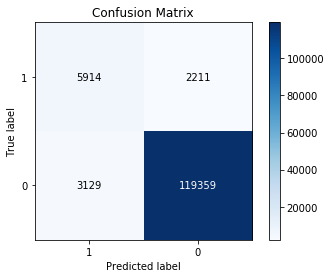

In [30]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(val_y, pred_val_bilstm_y_final,labels = [1,0])

In [31]:
pred_test_final = ( pred_test_bilstm_y > thresh_glLSTM).astype(np.int)
submission = pd.DataFrame.from_dict({'qid': test_df['qid']})
submission['prediction'] = pred_test_final
print(np.sum(submission.prediction)/(test_df.shape[0]))
submission.to_csv('submission.csv', index=False)


0.06866308680542621
